# W207 Summer 2018 Final Project 
---

**Authors:** Divya Gorantla, Ram Iyer, Tiffany Jaya, Steve Sanders <br/>
**Date:** 5 August 2018

---

## Table of Contents

1. [Introduction](#introduction)
2. [Exploratory Data Analysis](#eda)
  1. [Load libraries](#load-libraries)
  2. [Load data](#load-data)
  3. [Identify the train labels](#identify-the-train-labels)
  4. [Identify the train features](#identify-the-train-features)
  5. [Address concerns about the datasets](#address-concerns-about-the-datasets)
  6. [Univariate analysis](#univariate-analysis)
  7. [Bivariate analysis](#bivariate-analysis)
3. [Feature Engineering](#feature-engineering)
4. [Models](#models)
  1. [Model Results](#model-results)
5. [Ensemble Models](#ensemble-models)
  1. [Ensemble Results](#ensemble-results)
6. [Stack Models](#stack-models)
  1. [Stack Results](#stack-results)
7. [Conclusion](#conclusion)
8. [References](#references)
9. [Appendix](#appendix)
  1. [Cross Validation](#appendix-cv)
---

<a id='introduction'/>

## Introduction

Our goal in this project is to classify an observed 30 x 30 meter land into one of the seven forest cover types found in the Roosevelt National Forest of Northern Colarado: 

| Forest Cover Type  | Tree   | Leaf  | 
| ------------------ |:------:| -----:| 
| Spruce/Fir         | <img src='./img/spruce-tree.jpg' alt='Spruce tree' height='65px' width='65px'/><br /><img src='./img/fir-tree.jpg' alt='Fir tree' height='65px' width='65px'/> | <img src='./img/spruce.jpg' alt='Spruce leaf' height='65px' width='65px'/><br /><img src='./img/fir.jpg' alt='Fir leaf' height='65px' width='65px'/> | 
| Lodgepole Pine     | <img src='./img/lodgepole-pine-tree.jpg' alt='Lodgepole Pine tree' height='65px' width='65px'/> | <img src='./img/lodgepole-pine.jpg' alt='Lodgepole Pine leaf' height='65px' width='65px'/> | 
| Ponderosa Pine     | <img src='./img/ponderosa-pine-tree.jpg' alt='Ponderosa Pine tree' height='65px' width='65px'/> | <img src='./img/ponderosa-pine.jpg' alt='Ponderosa Pine leaf' height='65px' width='65px'/> |
| Cottonwood/Willow  | <img src='./img/cottonwood-tree.jpg' alt='Cottonwood tree' height='65px' width='65px'/><br /><img src='./img/willow-tree.jpg' alt='Willow tree' height='65px' width='65px'/> | <img src='./img/cottonwood.jpg' alt='Cottonwood leaf' height='65px' width='65px'/><br /><img src='./img/willow.jpg' alt='Willow leaf' height='65px' width='65px'/> |
| Aspen              | <img src='./img/aspen-tree.jpg' alt='Aspen tree' height='65px' width='65px'/> | <img src='./img/aspen.jpg' alt='Aspen leaf' height='65px' width='65px'/> | 
| Douglas-Fir        | <img src='./img/douglas-fir-tree.jpg' alt='Douglas-Fir tree' height='65px' width='65px'/> | <img src='./img/douglas-fir.jpg' alt='Douglas-Fir leaf' height='65px' width='65px'/> | 
| Krummholz <br />(stunted trees) | <img src='./img/krummholz-tree.jpg' alt='Krummholz tree' height='65px' width='65px'/> | |

Fortunately for us, 15,120 of these observations have been labeled to their respective forest cover types. We can then use this labeled dataset to train several different models and compare which model can best accurately classify the forest cover type based on just the cartographic information. 

What we have found is that random forest classifier perform best among the three models we have tested with an accuracy score of 77.2%.  


<a id='eda'/>

## Exploratory Data Analysis

All cartographic information that we use as features to determine the forest cover type has been collected by the US Geological Survey (USGS) and US Forest Service (USFS). The associating labels were derived separately by the USFS Region 2 Resource Information System. We download them from the Kaggle website via the Kaggle API. 

<a id='load-libraries'/>

### Load libraries

In [2]:
# general libraries
import itertools
import pandas as pd
import numpy as np

# plot libraries
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import scatter_matrix

# preprocessing (aka feature engineering)
from sklearn.preprocessing import normalize
from sklearn.preprocessing import StandardScaler

# model selection
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split

# model definition
from sklearn import svm as SVM
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

# ensemble
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier

# ensemble: boosting algorithms
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier

# model metrics
from sklearn.metrics import accuracy_score

# define the random_state
random_state = 7

<a id='load-data'/>

### Load data

We used the Kaggle API to download the data directly from the Kaggle website. 

To use the Kaggle API, please follow these instructions:

1. Login to your Kaggle account
2. Select 'My account'
3. Select 'Create New API Token'
4. Place the token 'kaggle.json' into ~/.kaggle

We decided to comment out the code relating to the use of Kaggle API since it was tested in a MAC OS and cannot guarantee reliability in other OS.

In [3]:
# install the Kaggle API library
#!pip install kaggle

# download each ZIP file from the Kaggle website via the Kaggle API
#!kaggle competitions download -c forest-cover-type-prediction -p ./data 

# define each downloaded file
TRAIN_FILENAME = 'train.csv'
TEST_FILENAME = 'test.csv'
SAMPLE_SUBMISSION_FILENAME = 'sampleSubmission.csv'

# define where the downloaded file will be stored
DATAPATH = './data/'

# unzip the files and load them as a panda DataFrame
def get_data(filename, unzip=False):
    '''Read CSV file (unzip or not) into a dataframe'''
    if unzip:
        zippath = DATAPATH + filename + '.zip'
        return pd.read_csv(zippath, compression='zip', header=0, sep=',', quotechar='"', index_col='Id')
    
    filepath = DATAPATH + filename
    return pd.read_csv(filepath, header=0, sep=',', quotechar='"', index_col='Id')

train = get_data(TRAIN_FILENAME, unzip=False)
test = get_data(TEST_FILENAME, unzip=False)
sample = get_data(SAMPLE_SUBMISSION_FILENAME, unzip=False)

In [4]:
# define the data
train_data = train.drop('Cover_Type', axis=1)
test_data = test

# define the labels
train_labels = train['Cover_Type']

In [5]:
# define additional labels, not defined in the dataset
cover_types = sorted(pd.unique(train['Cover_Type'])) # 1-7
cover_labels = ['Spruce/Fir', 'Lodgepole Pine', 'Ponderosa Pine', 'Cottonwood/Willow', 'Aspen', 'Douglas-fir', 'Krummholz']
wilderness_types = list(range(1,5)) # 1-4
wilderness_labels = ['Rawah', 'Neota', 'Comanche', 'Cache la Poudre']
soil_types = list(range(1,41)) # 1-40
soil_labels = ['Cathedral family', 
               'Vanet', 
               'Haploborolis', 
               'Ratake family',
               'Vanet family',
               'Vanet - Wetmore families',
               'Gothic family',
               'Supervisor',
               'Troutville family',
               'Bullwark - Catamount families',
               'Bullwark - Catamount families',
               'Legault family',
               'Catamount family',
               'Pachic Argiborolis',
               '',
               'Cryaquolis',
               'Gateview family',
               'Rogert family',
               'Typic Cryaquolis',
               'Typic Cryaquepts',
               'Typic Cryaquolls',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Leighcan family',
               'Granile',
               'Leighcan family',
               'Leighcan family',
               'Como - Legault families',
               'Como family',
               'Leighcan - Catamount families',
               'Catamount family',
               'Leighcan - Catamount families',
               'Cryorthents',
               'Cryumbrepts',
               'Bross family',
               'Cryumbrepts',
               'Leighcan - Moran families',
               'Moran family - Cryorthents',
               'Moran family - Cryorthents'
              ]
soil_descriptions = ['Rock outcrop complex, extremely stony',
                     'Ratake families complex, very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, rubbly',
                     'Rock outcrop complex, stony',
                     '',
                     'Limber families complex',
                     'very stony',
                     'Rock outcrop complex, rubbly',
                     'Rock land complex, rubbly',
                     ' Rock land complex, stony',
                     'Rock land - Bullwark family complex, rubbly',
                     'Aquolis complex',
                     '',
                     'Cryoborolis complex',
                     'Cryaquolis complex',
                     'very stony',
                     'Borohemists complex',
                     'Typic Cryaquolls complex',
                     'Leighcan family, till substratum complex',
                     'till substratum, extremely bouldery',
                     'till substratum, extremely bouldery',
                     'extremely stony',
                     'warm, extremely stony',
                     'Catamount families complex, very stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'complex, extremely stony',
                     'Rock land - Legault family complex, extremely stony',
                     'complex, extremely stony',
                     'Rock outcrop - Leighcan family complex, extremely stony',
                     'Rock outcrop complex, extremely stony',
                     'Rock land complex, extremely stony',
                     'Rock outcrop - Cryaquepts complex',
                     'Rock land - Cryumbrepts complex, extremely stony',
                     'Cryumbrepts - Cryorthents complex, extremely stony',
                     'Cryaquolls complex, extremely stony',
                     'Cryorthents - Leighcan family complex, extremely stony',
                     'Cryorthents - Rock land complex, extremely stony'
                    ]

numerical_feature_labels = [ 'Elevation (in meters)',
                             'Aspect (in degrees)',
                             'Slope (in degrees)',
                             'Horizontal Distance To Hydrology',
                             'Vertical Distance To Hydrology',
                             'Horizontal Distance To Roadways',
                             'Hillshade 9am (0 to 255 index)',
                             'Hillshade 12pm (0 to 255 index)',
                             'Hillshade 3pm  (0 to 255 index)',
                             'Horizontal Distance To Fire Points',
                    ]

In [6]:
#Create different categories of vars so we can do appropriate transformations

soil_vars        = ["Soil_Type" + str(i) for i in range(1,41)]
wilderness_vars  = ["Wilderness_Area" + str(i) for i in range(1,5)]
categorical_vars = soil_vars + wilderness_vars
numerical_vars   = train_data.columns[:10]

In [7]:
# Create a lookup table to easily map features to descriptions

lookup_cover_labels      = dict(zip(cover_types,cover_labels))
lookup_soil_labels       = dict(zip(soil_vars,soil_labels))
lookup_wilderness_labels = dict(zip(wilderness_vars,wilderness_labels))
lookup_numerical_labels  = dict(zip(numerical_vars,numerical_feature_labels))

In [11]:
# Specify the color to use for the train labels

rgb_values = sns.hls_palette(8).as_hex()

<a id='identify-the-train-labels'/>

### Identify the train labels

There are 2,160 observations for each of the seven forest cover types. The classes are represented equally, which is great news, because we do not have to concern ourselves with misleading classification accuracy, a common problem that plagues an imbalanced dataset.

7    2160
6    2160
5    2160
4    2160
3    2160
2    2160
1    2160
Name: Cover_Type, dtype: int64

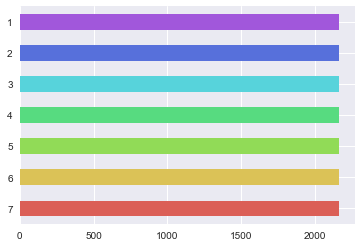

In [12]:
train_labels.value_counts().plot(kind='barh', color=rgb_values)
train_labels.value_counts()

<a id='identify-the-train-features'/>

### Identify the train features

In the train dataset, there are 15,120 observations with 54 features. 

In [13]:
print(train_data.shape)
train_data.columns

(15120, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

In the test dataset, there are 565,892 observations which includes the 54 features found in the train dataset. In other words, we have validated that the train dataset is a good dataset to use as it shares the same cartographic information as the test dataset.

In [14]:
print(test.shape)
test.columns

(565892, 54)


Index(['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology',
       'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
       'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
       'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1',
       'Wilderness_Area2', 'Wilderness_Area3', 'Wilderness_Area4',
       'Soil_Type1', 'Soil_Type2', 'Soil_Type3', 'Soil_Type4', 'Soil_Type5',
       'Soil_Type6', 'Soil_Type7', 'Soil_Type8', 'Soil_Type9', 'Soil_Type10',
       'Soil_Type11', 'Soil_Type12', 'Soil_Type13', 'Soil_Type14',
       'Soil_Type15', 'Soil_Type16', 'Soil_Type17', 'Soil_Type18',
       'Soil_Type19', 'Soil_Type20', 'Soil_Type21', 'Soil_Type22',
       'Soil_Type23', 'Soil_Type24', 'Soil_Type25', 'Soil_Type26',
       'Soil_Type27', 'Soil_Type28', 'Soil_Type29', 'Soil_Type30',
       'Soil_Type31', 'Soil_Type32', 'Soil_Type33', 'Soil_Type34',
       'Soil_Type35', 'Soil_Type36', 'Soil_Type37', 'Soil_Type38',
       'Soil_Type39', 'Soil_Type40

Looking at the features, it is interesting to note that we do not see longitude and latitude values, which means we cannot validate the cartographic information to the actual geographic location. The 54 features are summarized in the following table below:

| Name                               | Measurement     | Description                                               |
| ----------------------------------:| ---------------:| ---------------------------------------------------------:|
| Elevation                          | meters          | Height above sea level                                    |
| Aspect                             | degrees azimuth | Compass direction that a slope faces<br/>0: North, 90: East, 180: South, 270: West<br/>Potential influence on temperature and soil | 
| Slope                              | degrees         | Degree of incline of a surface<br/>In other words, maximum rate of change of elevation<br/>Has gradient and aspect as components                                                     | 
| Horizontal_Distance_To_Hydrology   | meters          | Horizontal Distance to the nearest surface water features | 
| Vertical_Distance_To_Hydrology     | meters          | Vertical Distance to the nearest surface water features   | 
| Horizontal_Distance_To_Roadways    | meters          | Horizontal distance to the nearest roadway                | 
| Horizontal_Distance_To_Fire_Points | meters          | Horizontal distance to the nearest wildfire ignition points | 
| Hillshade_9am                      | 0 (dark) to 255 (light) | Hillshade index at 9 AM, summer solstice | 
| Hillshade_Noon                     | 0 (dark) to 255 (light) | Hillshade index at 12 PM, summer solstice | 
| Hillshade_3pm                      | 0 (dark) to 255 (light) | Hillshade index at 3 PM, summer solstice | 
| Wilderness_Area (4 binary columns) | 0 (absent) or 1 (present) | Wilderness area designation<br/>1: Rawah, 2: Neota, 3: Comanche, 4: Cache la Poudre | 
| Soil_Type (40 binary columns)      | 0 (absent) or 1 (present) | Soil type designation |



<a id='address-concerns-about-the-datasets' />

### Address concerns about the datasets

In order for us to confidently apply the datasets onto the models, we first take a look at the size of the training set and compare it to the test set. Unfortunately, the number of observations in the training set is substantially fewer than the number of observations in the test set. With less training data, the parameter estimates that we determined from our models can have greater variance in the accuracy prediction. On a positive note, if we are more concerned about estimating the actual error of our model, having a bigger test set can help in achieving this. For this reason, we consider it to be not a substantial issue to use the training dataset despite the size difference.

In [15]:
# compare the relative sizes of the train and test dataset
train_size = train_data.shape[0]
test_size = test_data.shape[0]
total_size = train_size + test_size
print('train size', train_size)
print('test size', total_size)
print('percentage of train dataset: {:.2f}%'.format(train_size/total_size*100))
print('percentage of test dataset: {:.2f}%'.format(test_size/total_size*100))

train size 15120
test size 581012
percentage of train dataset: 2.60%
percentage of test dataset: 97.40%


In [23]:
train_data.describe()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
count,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,...,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000,15120.000000
mean,2749.322553,156.676653,16.501587,227.195701,51.076521,1714.023214,212.704299,218.965608,135.091997,1511.147288,...,0.021958,0.045635,0.040741,0.001455,0.006746,0.000661,0.002249,0.048148,0.043452,0.030357
std,417.678187,110.085801,8.453927,210.075296,61.239406,1325.066358,30.561287,22.801966,45.895189,1099.936493,...,0.146550,0.208699,0.197696,0.038118,0.081859,0.025710,0.047368,0.214086,0.203880,0.171574
min,1863.000000,0.000000,0.000000,0.000000,-146.000000,0.000000,0.000000,99.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2376.000000,65.000000,10.000000,67.000000,5.000000,764.000000,196.000000,207.000000,106.000000,730.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2752.000000,126.000000,15.000000,180.000000,32.000000,1316.000000,220.000000,223.000000,138.000000,1256.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,3104.000000,261.000000,22.000000,330.000000,79.000000,2270.000000,235.000000,235.000000,167.000000,1988.250000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,3849.000000,360.000000,52.000000,1343.000000,554.000000,6890.000000,254.000000,254.000000,248.000000,6993.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


/Users/tiffapedia/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2881: FutureWarning: 
mpl_style had been deprecated and will be removed in a future version.
Use `matplotlib.pyplot.style.use` instead.

  exec(code_obj, self.user_global_ns, self.user_ns)


1          Axes(0.1,0.7125;0.235294x0.1875)
2     Axes(0.382353,0.7125;0.235294x0.1875)
3     Axes(0.664706,0.7125;0.235294x0.1875)
4         Axes(0.1,0.43125;0.235294x0.1875)
5    Axes(0.382353,0.43125;0.235294x0.1875)
6    Axes(0.664706,0.43125;0.235294x0.1875)
7            Axes(0.1,0.15;0.235294x0.1875)
dtype: object

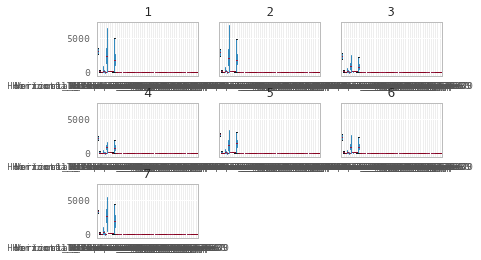

In [25]:
pd.options.display.mpl_style='default'
train_data.groupby(train_labels).boxplot()

TODO: figure out a better boxplot for outliers

TypeError: unhashable type: 'slice'

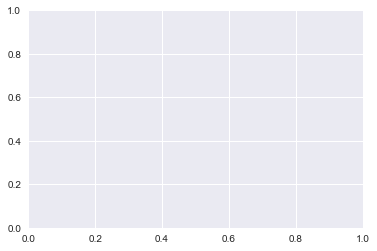

In [18]:
plt.boxplot(train_data)

In [ ]:
print('any missing values? {}'.format(train.isnull().sum().sum() > 0))


<a id='univariate-analysis' />

### Univariate Analysis

By overlaying the histogram for each forest cover type, we can immediately see that elevation will play a great role in identifying the cover types because the cover types rarely overlaps each other compared to the other features.

TODO
- label all plot axes and provide titles
- for the plots having relatively small text, we can improve the resolution by using a version of the following, for example: plt.figure(figsize=(9,6), dpi=1200)
  - Unfortunately, 1200 is too high of a dpi. 1000 is also too high of a dpi.

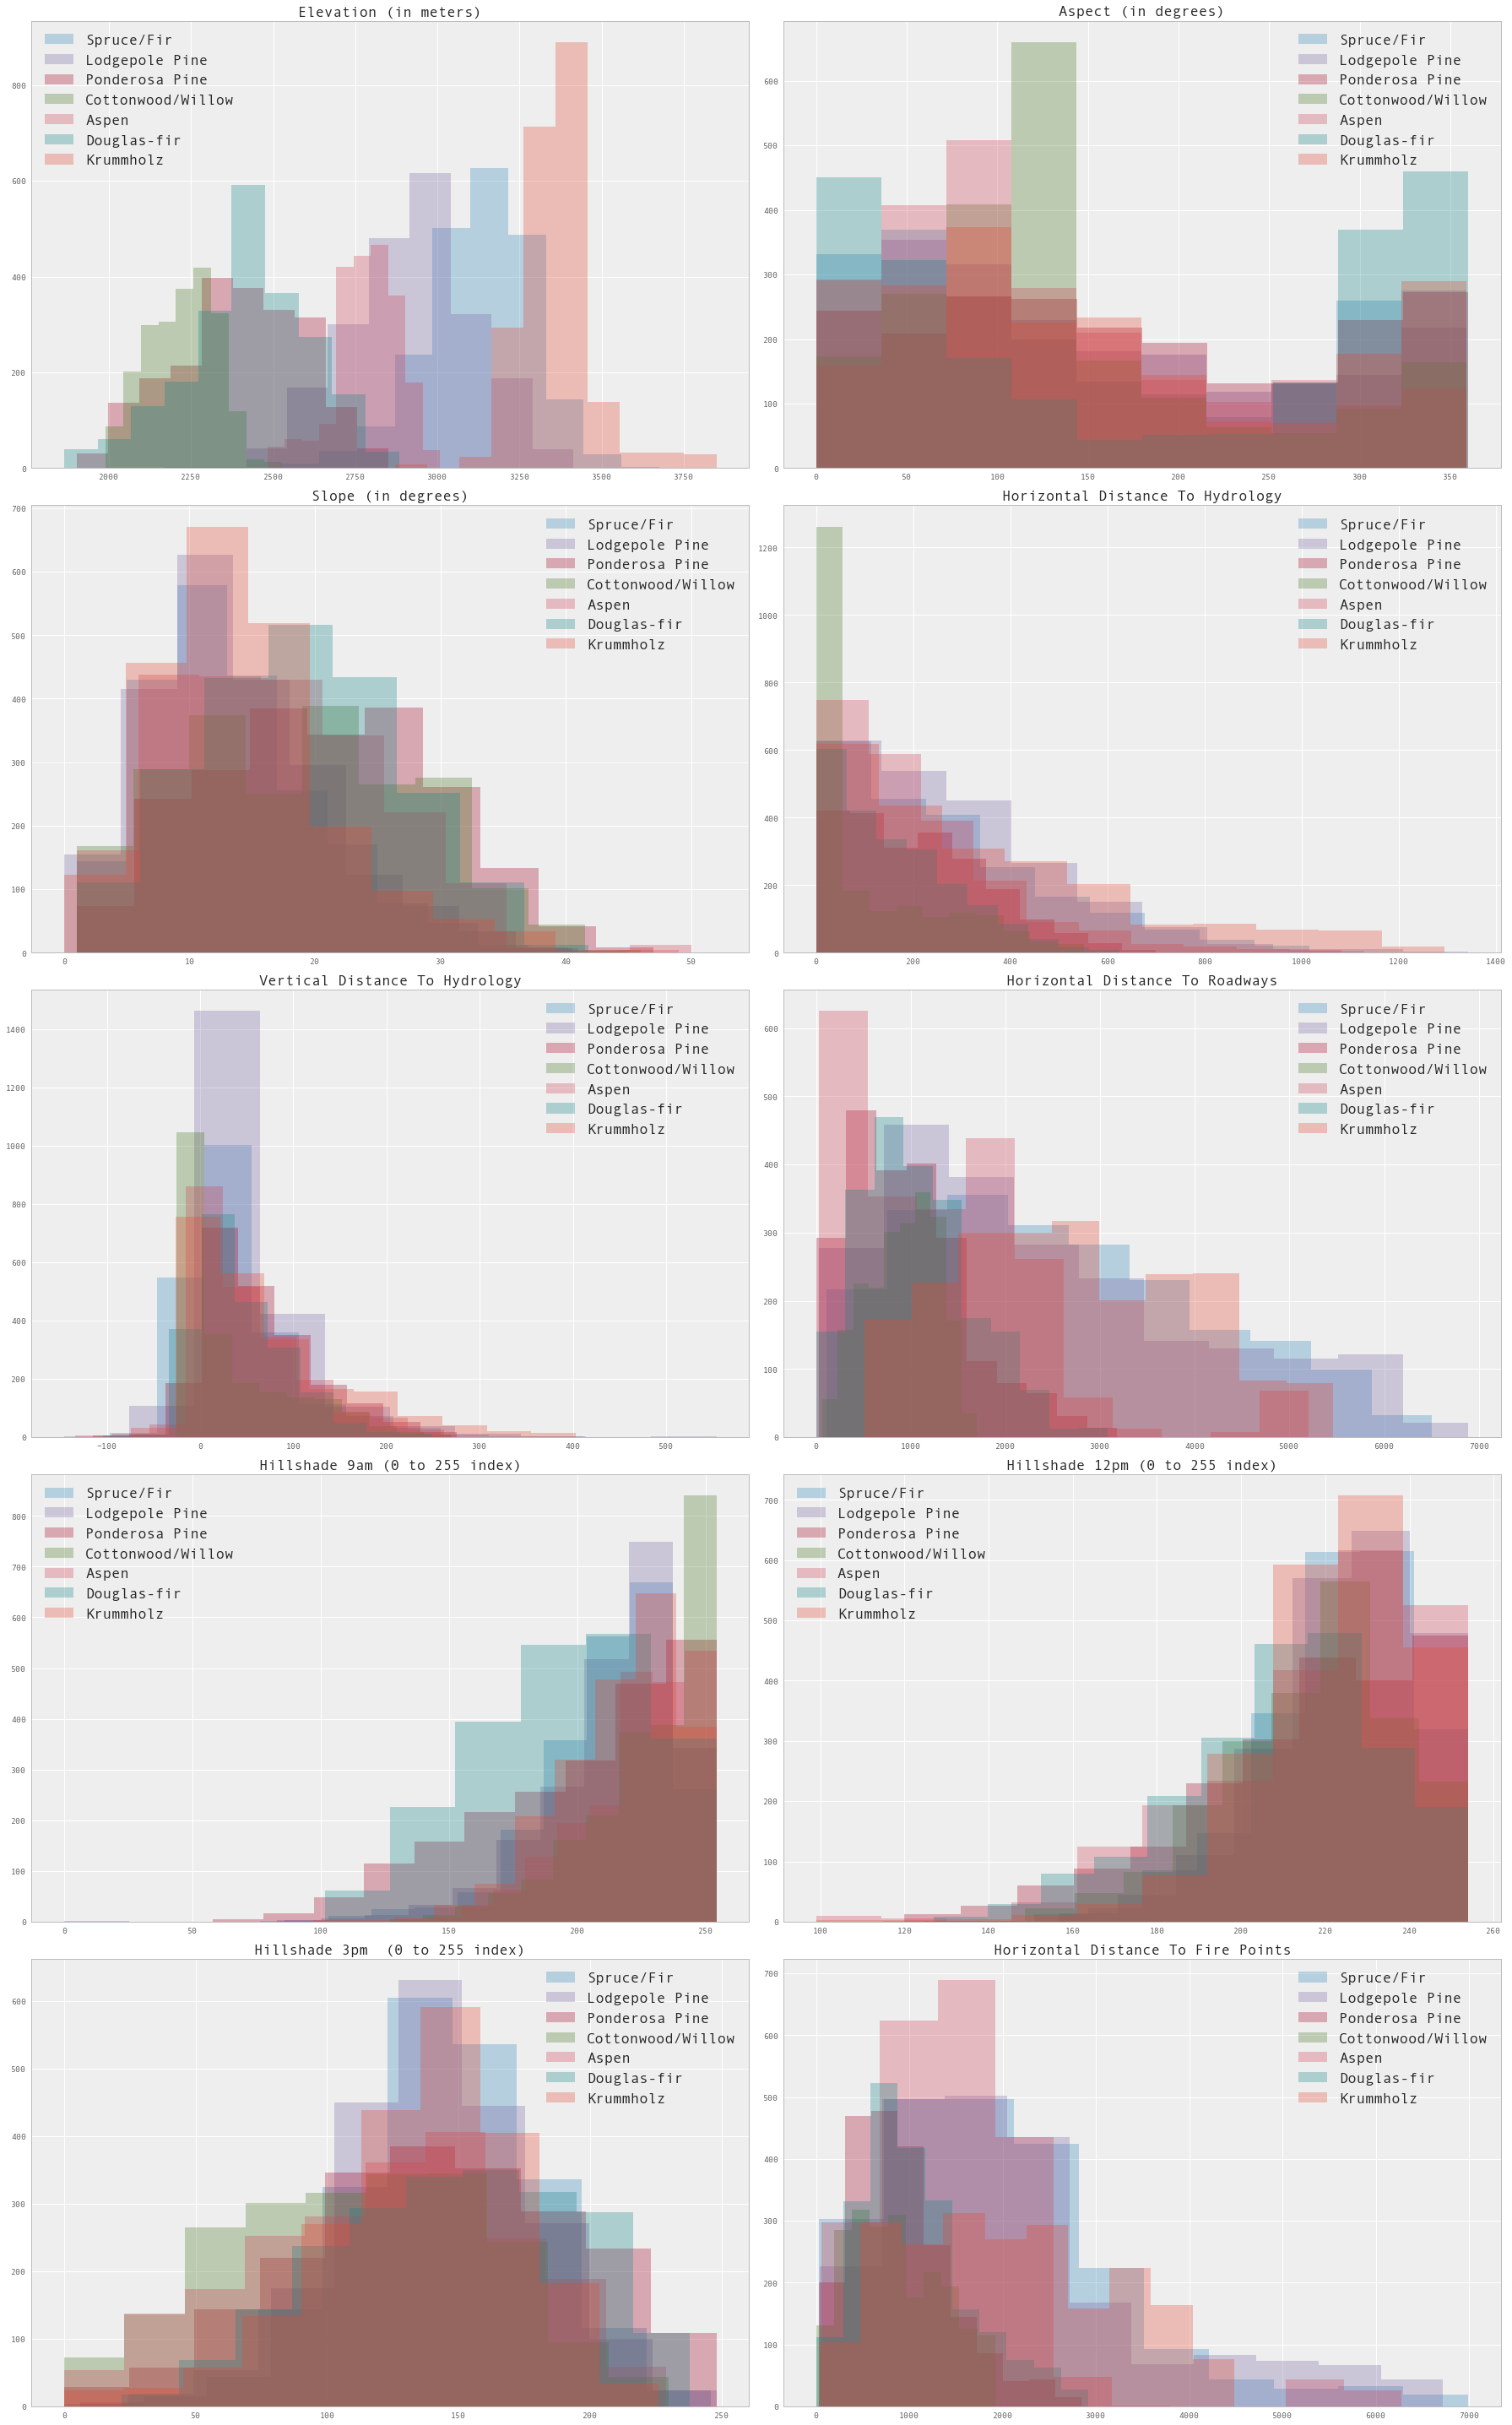

In [30]:


def plot_histogram (feature_name, description, axis):
    for label, data in train.groupby('Cover_Type')[feature_name]:
        data.hist(alpha=0.3, ax=axis)
        axis.set_title(description, fontsize='xx-large')
        axis.legend(labels=cover_labels, fontsize='xx-large')

#Plot histogram of continuous variables

ncols = 2
nrows = len(numerical_vars)//2

fig, axes = plt.subplots(nrows=nrows,ncols=ncols, figsize = (25,40))

for plot_indx, feature_name in enumerate(numerical_vars):
    i = plot_indx//2
    j = plot_indx - (2*i)
    plot_histogram(feature_name,lookup_numerical_labels[feature_name],axes[i,j])

fig.tight_layout()
plt.show()

#### Elevation

From the graph shown above, it appears that the cover types most commonly found at the high altitude is Krummholz (which is not surprising because Krummholz are stunted windblown trees situated typically on the top of the mountain) followed by the following cover types found in descending order of altitudes:

* Krummholz
* Spruce/Fir
* Lodgepole Pine
* Aspen
* Ponderosa Pine
* Douglas-fir
* Cottonwood/Willow

In [ ]:

# TODO: add 3D drawing of elevation vs aspect vs slope
# TODO: also add range

from mpl_toolkits.mplot3d import Axes3D
fig,ax = plt.subplots(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(train_data['Aspect'], train_data['Slope'], train_data['Elevation'], c=train['Cover_Type'], s=60)
ax.set_xlabel('Aspect')
ax.set_ylabel('Slope')
ax.set_zlabel('Elevation')

ax.view_init(30, 185)
ax.legend(labels=cover_labels)
plt.show()


#### Aspect

From the polar plot, it reconfirms that elevation plays a greater role in identifying the cover type. There's a cover type in almost every aspect (360 degree).

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,10))
ax = plt.subplot(111, projection='polar')
ax.scatter(train['Aspect'],train['Elevation'], c=train['Cover_Type'], cmap='hsv', alpha=0.3);
ax.legend(labels=cover_labels)

In [ ]:
# TODO: add 3D drawing of elevation vs aspect vs slope

#### Slope

TODO: describe slope

In [ ]:
# TODO: add 3D drawing of elevation vs aspect vs slope

#### Horizontal and Vertical Distance to Hydrology

TODO: add description

The distance-based features have substantial right-hand skew.   

Vertical_Distance_to_Hydrology has several negative values.  



In [ ]:
# TODO: add drawing of distance

#### Horizontal Distance to Roadways

TODO: add description

In [ ]:
# TODO: add drawing of distance

#### Horizontal Distance to Firepoints

TODO: add description

In [ ]:
# TODO: add drawing of distance

#### Hillshade

TODO: add description reword

Hillshade_3pm has several zero values that appear to be out of place (i.e., "missing values"). Hillshade_9am and Hillshade_Noon are truncated at 255, which is the maximum value of the index.



In [ ]:
# TODO: add different color shade 

Looking at the relationship between hillshade 3 PM and 9 AM, they've clear negative correlation while 3 PM and noon have positive correlation.

In [ ]:
with sns.axes_style('white'): 
    smaller_frame = train_data[['Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']] 
    scatter_matrix(smaller_frame, alpha=0.8, figsize=(10, 10), diagonal="kde", c=train_labels, s=50, cmap='rainbow') # can also use cmap=plt.cm.BrBG
plt.show();

There are clearly hillshade values at 3 PM that are zeroes. 

In [ ]:
plt.figure(figsize=(12,8)) 
plt.scatter(train_data['Hillshade_3pm'], train_data['Hillshade_Noon'], c=train_labels, s=50, cmap='rainbow') # can also use cmap=plt.cm.BrBG
plt.xlabel('Hillshade @ 3 PM') 
plt.ylabel('Hillshade @ Noon') 
plt.show();

In [ ]:
plt.figure(figsize=(12,8)) 
plt.scatter(train_data['Hillshade_3pm'], train_data['Hillshade_9am'], c=train_labels, s=50, cmap='rainbow') 
plt.xlabel('Hillshade @ 3 PM') 
plt.ylabel('Hillshade @ 9 AM')
plt.show();

Look at Hillshade as a function of slope and aspect

In [ ]:
with sns.axes_style('white'): 
    smaller_frame = train_data[['Slope','Aspect','Hillshade_9am', 'Hillshade_Noon','Hillshade_3pm']] 
    scatter_matrix(smaller_frame, alpha=0.8, figsize=(10, 10), diagonal="kde") 
plt.show();

In [ ]:
# Inserting this for reference (can be removed later based on redundancy.)

# See how the other continuous features are related.
with sns.axes_style('white'): 
    other_cont = train[['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points']] 
    scatter_matrix(other_cont, alpha=0.8, figsize=(16, 16), diagonal="kde", c=train['Cover_Type'], cmap='rainbow')   # can also use cmap=plt.cm.BrBG
    plt.show()
    

#### Wilderness Areas

Based on wilderness area, we noted that:

* Spruce/Fir (1) is located in Rawah (1), Neota (2), Comanche (3)
* Lodgepole Pine (2) is located in all wilderness area, with the most notable in Rawah (1) and Comanche (2)
* Ponderosa Pine (3) is located in Comanche (3) and Cache la Poudre(4)
* Cottonwood/Willow (4) is located only in Cache la Poudre (4)
* Aspen (5) is located in Rawah (1) and Comanche (3)
* Douglas-fir (6) is located in Comanche (3) and Cache la Poudre (4)
* Krummholz (7) is located in Cover (1), Neota (2), Comanche (3)

For this reason, wilderness area is a substantial feature to use to determine a cover type.

In [ ]:
freq_ct_wilderness_1 = pd.crosstab(train_data['Wilderness_Area1'], train_labels).iloc[1].tolist()
freq_ct_wilderness_2 = pd.crosstab(train_data['Wilderness_Area2'], train_labels).iloc[1].tolist()
freq_ct_wilderness_3 = pd.crosstab(train_data['Wilderness_Area3'], train_labels).iloc[1].tolist()
freq_ct_wilderness_4 = pd.crosstab(train_data['Wilderness_Area4'], train_labels).iloc[1].tolist()
freq_ct_wilderness = pd.DataFrame([freq_ct_wilderness_1, freq_ct_wilderness_2, freq_ct_wilderness_3, freq_ct_wilderness_4], 
                                  columns=cover_labels, 
                                  index=wilderness_labels)
freq_ct_wilderness.T.plot(kind='barh', stacked=False,figsize=(10,8));

In [ ]:
# TODO: add title, axis

#### Soil

As you can see below, each cover type sits on a broad range of soils. In addition, there seems to be repeated types of soil separated into multiple categories. For this reason, soil is not a good feature to determine cover types.

During our analysis, we ignore soil type 7 and 15 because these soil types are absent in our sample.

In [ ]:
print(pd.unique(train['Soil_Type7']))
print(pd.unique(train['Soil_Type15']))

In [ ]:
list_freq_ct_wilderness = []
for i in soil_types:
    # ignore soil type: 7, 15
    if i not in (7, 15):
        soil_type = 'Soil_Type{}'.format(i)
        pd.crosstab(train[soil_type], train['Cover_Type']).iloc[1].tolist()
        list_freq_ct_wilderness.append(pd.crosstab(train[soil_type], train['Cover_Type']).iloc[1].tolist())

soil_labels_wo_7_15 = [soil_label for ignore_label, soil_label in enumerate(soil_labels) if ignore_label not in [7,15]]
freq_ct_soil = pd.DataFrame(list_freq_ct_wilderness, 
                            columns=cover_labels, 
                            index=soil_labels_wo_7_15)
freq_ct_soil

In [ ]:
# TODO: look at soil by wilderness area

<a id='bivariate-analysis' />

### Bivariate Analysis

TODO: explain correlation matrix

In [ ]:
#sns.pairplot(train_data)
#sns.plt.show();

In [ ]:
continuous_vars = ['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Horizontal_Distance_To_Fire_Points', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']

plt.figure(figsize=(14, 10))
cmap = sns.diverging_palette(10, 220, as_cmap=True)
correlations = train_data[continuous_vars].corr()
# print correlations
print(sns.heatmap(correlations, cmap=cmap))

This correlation plot shows strong positive correlations between: horizontal and vertical distances to hydrology; between horizontal distances to roadways and horizontal distance to fire points; between Hillshade_Noon and Hillshade_3pm.  

Strong negative correlations are observed between Hillshade_9am and Hillshade_3pm; between Hillshade_9am and Aspect; betwen Hillshade_Noon and Slope.   

http://www.sthda.com/english/wiki/correlation-matrix-a-quick-start-guide-to-analyze-format-and-visualize-a-correlation-matrix-using-r-software

<a id='feature-engineering' />

## Feature Engineering


In [ ]:
# make a copy of the train data to be modified
fe_train_data = train_data.copy()
fe_train_labels = train_labels.copy()

In [ ]:
# employ a baseline model for comparison
def compare_baseline(data, labels,clf=None):
    BASELINE_MEAN = 0.7762
    BASELINE_SD = 0.0412
    if clf == None:
        clf = RandomForestClassifier(n_estimators=50, max_depth=76,random_state=random_state)
        #clf.fit(data, labels)
    scores = cross_val_score(clf, data, labels, cv=10)
    if np.mean(scores) > BASELINE_MEAN:
        print('Improve')
    else:
        print('Worsen')
    print('mean = {} ({})'.format(round(np.mean(scores), 4), BASELINE_MEAN))
    print('sd = {} ({})'.format(round(np.std(scores), 4), BASELINE_SD))

### 0. Replace Zeros in Hillshade_3pm

In [ ]:
# Replace the zeros in Hillshade_3pm

# Find instances of Hillshade_3pm=0
zero_Hillshade_3pm = fe_train_data.Hillshade_3pm[fe_train_data['Hillshade_3pm']==0]
zero_Hillshade_9am = fe_train_data.Hillshade_9am[fe_train_data['Hillshade_3pm']==0]

# Get non-zero Hillshade_3pm data to do polynomial fit, along with corresponding Hillshade_9am data
non_zero_Hillshade_3pm = fe_train_data.Hillshade_3pm[fe_train_data['Hillshade_3pm']!=0]
non_zero_Hillshade_9am = fe_train_data.Hillshade_9am[fe_train_data['Hillshade_3pm']!=0]

In [ ]:
# do polynomial fit of Hillshade_3pm ~ f(Hillshade_9am)

from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly_9 = poly.fit_transform(non_zero_Hillshade_9am.values.reshape(-1, 1))
#print(poly_9.shape)

from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(poly_9, non_zero_Hillshade_3pm.values.reshape(-1, 1))

poly_9_zero = poly.transform(zero_Hillshade_9am.values.reshape(-1, 1))

new_3pm = lr.predict(poly_9_zero)
#print('new_3pm shape', new_3pm.shape)

In [ ]:
indexer = fe_train_data[fe_train_data.Hillshade_3pm==0].index

for i, indx in enumerate(indexer):
    fe_train_data.Hillshade_3pm[fe_train_data.index==indexer[i]] = new_3pm[i]

# view results
#print('Hillshade_3pm=0 values replaced as shown by red data points')
plt.scatter(fe_train_data['Hillshade_9am'], fe_train_data['Hillshade_3pm'])
plt.scatter(zero_Hillshade_9am.values.reshape(-1, 1), new_3pm, color='red')
plt.xlim((0,250))
plt.ylim((0,250))
plt.xlabel('Hillshade_9am')
plt.ylabel('Hillshade_3pm')

Hillshade_3pm=0 values replaced as shown by red data points.

In [ ]:
compare_baseline(fe_train_data, fe_train_labels)

Replacing the zero values results in a small accuracy improvement relative to the baseline.

### 1. Normalize Hillshade

In [ ]:
normalize_hillshade = normalize(train_data[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']], axis=0)
plt.hist(normalize_hillshade);

In [ ]:
fe_train_data['Hillshade_9am'] = normalize_hillshade[:, 0]
fe_train_data['Hillshade_Noon'] = normalize_hillshade[:, 1]
fe_train_data['Hillshade_3pm'] = normalize_hillshade[:, 2]

In [ ]:
compare_baseline(fe_train_data, fe_train_labels)

### 2. Feature Scaling

To ensure that all numerical values are seen as "equally weighted" by the algorithm, we scale all of the features with 0 as the mean and 1 as standard deviation (standard normal distribution). We scale the test dataset using the training dataset parameters to ensure the numerical values are seen as "equally weighted."

TODO: I don't know if we wanted to feature scale the entire dataset

In [ ]:
sc = StandardScaler()
sc.fit(fe_train_data)
compare_baseline(sc.transform(fe_train_data), fe_train_labels)

In [ ]:
fe_train_data = sc.transform(fe_train_data)
#test_data = sc.transform(test_data)

In [ ]:
train_data.columns

<a id='models' />

### 3. Negative_Vertical_Distance_To_Hydrology (assumes unscaled starting data...)

In [ ]:
# Create new training variable based on if Vertical_Distance_To_Hydrology is negative 
# and test to see if it improves the baseline results

fe_train_data['Hydrology_Distance_Is_Negative'] = fe_train_data['Vertical_Distance_To_Hydrology'] < 0
#print('Number of samples having negative Vertical_Distance_To_Hydrology:', fe_train_data.Hydrology_Distance_Is_Negative.sum()) #1139

compare_baseline(fe_train_data, fe_train_labels)

### Additional Features to add/try after scaling??

In [ ]:
#Create two new columns named Slope hydrology and Slope hydrology percent and remove any infinite values that may result
fe_train_data['slope_hyd'] = np.sqrt(fe_train_data.Vertical_Distance_To_Hydrology**2    +  \
                                fe_train_data.Horizontal_Distance_To_Hydrology**2)
fe_train_data.slope_hyd=fe_train_data.slope_hyd.map(lambda x: 0 if np.isinf(x) else x) 

#fe_train_data['slope_hyd_pct'] = fe_train_data.Vertical_Distance_To_Hydrology / fe_train_data.Horizontal_Distance_To_Hydrology 

#compare_baseline(fe_train_data, fe_train_labels)


In [ ]:
#Elevation adjusted by Horizontal distance to Hydrology 
fe_train_data['Elev_to_HD_Hyd']=fe_train_data.Elevation - 0.2 * fe_train_data.Horizontal_Distance_To_Hydrology 

#compare_baseline(fe_train_data, fe_train_labels)

In [ ]:
#Elevation adjusted by Horizontal distance to Roadways 
fe_train_data['Elev_to_HD_Road']=fe_train_data.Elevation - 0.05 * fe_train_data.Horizontal_Distance_To_Roadways

#compare_baseline(fe_train_data, fe_train_labels)

In [ ]:
#Elevation adjusted by Vertical distance to Roadways 
fe_train_data['Elev_to_VD_Hyd']=fe_train_data.Elevation - fe_train_data.Vertical_Distance_To_Hydrology

#compare_baseline(fe_train_data, fe_train_labels)

In [ ]:
#Mean distance to Amenities 
fe_train_data['Mean_Amenities'] = (fe_train_data.Horizontal_Distance_To_Fire_Points + fe_train_data.Horizontal_Distance_To_Hydrology + fe_train_data.Horizontal_Distance_To_Roadways) / 3

#compare_baseline(fe_train_data, fe_train_labels)

In [ ]:
#Mean Distance to Fire and Water 
fe_train_data['Mean_Fire_Hyd']=(fe_train_data.Horizontal_Distance_To_Fire_Points + fe_train_data.Horizontal_Distance_To_Hydrology) / 2 

#compare_baseline(fe_train_data, fe_train_labels)

### TODO: Need to add "successful" new features to the test data....

### Class Definitions

In [ ]:
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_union
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingClassifier
import math

hillshade_vars = ['Hillshade_9am','Hillshade_Noon','Hillshade_3pm']
distance_vars  = ['Elevation','Horizontal_Distance_To_Hydrology',
                  'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways',
                  'Horizontal_Distance_To_Fire_Points'
                 ]
degree_vars    = ['Aspect','Slope']

train_data['euclidean'] = train_data['Horizontal_Distance_To_Hydrology']**2 + train_data['Vertical_Distance_To_Hydrology']**2


class SelectFeatures(TransformerMixin):
    
    def __init__(self, columns):
        self.columns = columns
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        return X[self.columns]


class AddEuclidean(TransformerMixin):
    
    def __init__(self,column1,column2):
        self.column1 = column1
        self.column2 = column2
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        euclidean_feature = X[self.column1]**2 + X[self.column2]**2 
        euclidean_feature = euclidean_feature.apply(math.sqrt)
        return pd.DataFrame(euclidean_feature)

class AddSquare(TransformerMixin):
    
    def __init__(self,column):
        self.column = column
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        square_feature = X[self.column]**2 
        return pd.DataFrame(square_feature)
    
class AddLog():
    
    def __init__(self,column):
        self.column = column
   
    def fit(self, X, y=None, **fit_params):
        return self
    
    def transform(self, X, **transform_params):
        log_feature = np.log(X[self.column] + 1)
        return pd.DataFrame(log_feature)

class CreateGroup():

    def __init__(self,column1,column2):
        self.column1 = column1
        self.column2 = column2

    def fit(self, X, y=None, **fit_params):
        return self

    def transform(self, X, **transform_params):
        group_feature = (X[self.column1] <= self.column2)*1
        return pd.DataFrame(group_feature)

# trasformer for stacking
class ModelTransformer(TransformerMixin):

    def __init__(self, model):
        self.model = model

    def fit(self, *args, **kwargs):
        self.model.fit(*args, **kwargs)
        return self

    def transform(self, X, **transform_params):
        return pd.DataFrame(self.model.predict_proba(X))
    

### Pipeline Definitions

In [ ]:
# Pipeline to Normalize hillshades, robustScale other numerical vars

horiz_dist = 'Horizontal_Distance_To_Hydrology'
vert_dist  = 'Vertical_Distance_To_Hydrology'
rem_dist_vars = list(set(distance_vars) - set([horiz_dist,vert_dist]))

union = make_union(make_pipeline(SelectFeatures(rem_dist_vars),StandardScaler()),
                   make_pipeline(SelectFeatures(hillshade_vars),StandardScaler()),
                   make_pipeline(AddEuclidean(horiz_dist,vert_dist),StandardScaler()),
                   SelectFeatures(categorical_vars))

RF = RandomForestClassifier(n_estimators=50, max_depth=76,random_state=random_state)
pipe_clf = make_pipeline(union,RF)

compare_baseline(train_data,train_labels,pipe_clf)


### Feature union and estimator

In [ ]:
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('distance', Pipeline([
            ('select', SelectFeatures(distance_vars)),
            ('scale', StandardScaler())
        ])),
        ('hillshade', Pipeline([
            ('select', SelectFeatures(hillshade_vars)),
            ('scale', StandardScaler())
        ])),
        ('categorical', SelectFeatures(categorical_vars)),
        ('elevation_square', AddSquare('Elevation')),
        ('log_roadway', AddLog('Horizontal_Distance_To_Roadways')),
        ('log_fire', AddLog('Horizontal_Distance_To_Fire_Points'))
        #         ('group_aspect', CreateGroup('Aspect', 220))
    ])),
    ('estimator',RandomForestClassifier(n_estimators=50, max_depth=76,random_state=random_state))
])

compare_baseline(train_data,train_labels,pipeline)

### Stacked models

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('distance', Pipeline([
            ('select', SelectFeatures(distance_vars)),
            ('scale', StandardScaler())
        ])),
        ('hillshade', Pipeline([
            ('select', SelectFeatures(hillshade_vars)),
            ('scale', StandardScaler())
        ])),
        ('categorical', SelectFeatures(categorical_vars)),
        ('elevation_square', AddSquare('Elevation')),
        ('log_roadway', AddLog('Horizontal_Distance_To_Roadways')),
        ('log_fire', AddLog('Horizontal_Distance_To_Fire_Points')),
    ])),
    #stacking
    ('estimators', FeatureUnion([
        ('dtr', ModelTransformer(DecisionTreeClassifier(min_samples_split= 10, min_samples_leaf= 5, max_depth= 10, random_state= random_state))),
        ('knn', ModelTransformer(KNeighborsClassifier(n_neighbors=9))),
    ])),
    ('estimator', RandomForestClassifier(n_estimators=50, max_depth=76,random_state=random_state))
])
compare_baseline(train_data,train_labels,pipeline)

In [ ]:
###  More models

In [ ]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier


pipeline = Pipeline([
    ('features', FeatureUnion([
        ('distance', Pipeline([
            ('select', SelectFeatures(distance_vars)),
            ('scale', StandardScaler())
        ])),
        ('hillshade', Pipeline([
            ('select', SelectFeatures(hillshade_vars)),
            ('scale', StandardScaler())
        ])),
        ('categorical', SelectFeatures(categorical_vars)),
        ('elevation_square', AddSquare('Elevation')),
        ('log_roadway', AddLog('Horizontal_Distance_To_Roadways')),
        ('log_fire', AddLog('Horizontal_Distance_To_Fire_Points')),
    ])),
    ('estimator',AdaBoostClassifier(base_estimator= RandomForestClassifier(n_estimators=50, max_depth=76,random_state=random_state), n_estimators=50, random_state=random_state))
])

compare_baseline(train_data,train_labels,pipeline)

In [ ]:
from sklearn.ensemble import VotingClassifier

# create the sub models
estimators = []
model1 = DecisionTreeClassifier(min_samples_split= 10, min_samples_leaf= 5, max_depth= 10, random_state= random_state)
estimators.append(('decision', model1))
model2 = KNeighborsClassifier(n_neighbors=9)
estimators.append(('cart', model2))

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('distance', Pipeline([
            ('select', SelectFeatures(distance_vars)),
            ('scale', StandardScaler())
        ])),
        ('hillshade', Pipeline([
            ('select', SelectFeatures(hillshade_vars)),
            ('scale', StandardScaler())
        ])),
        ('categorical', SelectFeatures(categorical_vars)),
        ('elevation_square', AddSquare('Elevation')),
        ('log_roadway', AddLog('Horizontal_Distance_To_Roadways')),
        ('log_fire', AddLog('Horizontal_Distance_To_Fire_Points')),
    ])),
    ('estimator',VotingClassifier(estimators))
])

compare_baseline(train_data,train_labels,pipeline)

In [ ]:
import xgboost as xgb

pipeline = Pipeline([
    ('features', FeatureUnion([
        ('distance', Pipeline([
            ('select', SelectFeatures(distance_vars)),
            ('scale', StandardScaler())
        ])),
        ('hillshade', Pipeline([
            ('select', SelectFeatures(hillshade_vars)),
            ('scale', StandardScaler())
        ])),
        ('categorical', SelectFeatures(categorical_vars)),
        ('elevation_square', AddSquare('Elevation')),
        ('log_roadway', AddLog('Horizontal_Distance_To_Roadways')),
        ('log_fire', AddLog('Horizontal_Distance_To_Fire_Points')),
    ])),
    ('estimator', xgb.XGBClassifier(objective= 'multi:softmax'))
])
compare_baseline(train_data,train_labels,pipeline)

In [ ]:
from sklearn.neural_network import MLPClassifier
pipeline = Pipeline([
    ('features', FeatureUnion([
        ('distance', Pipeline([
            ('select', SelectFeatures(distance_vars)),
            ('scale', StandardScaler())
        ])),
        ('hillshade', Pipeline([
            ('select', SelectFeatures(hillshade_vars)),
            ('scale', StandardScaler())
        ])),
        ('categorical', SelectFeatures(categorical_vars)),
        ('elevation_square', AddSquare('Elevation')),
        ('log_roadway', AddLog('Horizontal_Distance_To_Roadways')),
        ('log_fire', AddLog('Horizontal_Distance_To_Fire_Points')),
    ])),
    ('estimator',MLPClassifier(activation = 'tanh', alpha = 1, hidden_layer_sizes=(50,75), random_state=random_state))
])

compare_baseline(train_data,train_labels,pipeline)

In [ ]:
train_data.head()

## Models

Based on our intuition of the use case, the problem that we are trying to solve is a multi-class classification problem. We come to this conclusion because we are trying to fit 54 features (of cartographic information) into 7 classes (of forest cover types). For this reason, we will look into multi-class classification methods to see which model performs the best classification of the problem at hand. 

The multi-class classification methods that we will compare are:

1. Logistic Regression (LR): skip because of failure to converge on multiple occassion
2. Naive Bayes (NB)
3. K-Nearest Neighbors (KNN)
4. Support Vector Machine (SVM)
5. Decision Tree (DT)
6. Neural Network (NN)

To determine which model predicts with the highest accuracy, we will perform a cross-validation check using randomized search (RandomizedSearchCV). The reason why we chose cross-validation over train/test split is because cross-validation will create multiple train/test splits. The average accuracy resulted from each split provides a lower variance estimate compare to that of train/test split because accuracy changes drastically based on what is in the test set.

We also chose randomized search (RandomizedSearchCV) over grid search (GridSearchCV) to reduce the computational time. Unlike grid search, randomized search does not iterate over each parameter simulatenously, allowing us to have computational control at the cost of a slightly worse performance. 

***Note: train/test split model selection and simple cross validation (using cross_val_score) can be found in the <a id='appendix-cv'>appendix</a> section.***

In [ ]:
# define the score to beat
# which is currently the probability of randomly guessing the forest cover type correctly
best_accuracy = np.round(1/7, 4)

In [ ]:
# --------------------------------------------------------------------------------
# Randomized Search Cross Validation 
# --------------------------------------------------------------------------------

# define variable to store output
output_rscv = [None] * 6

# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', max_iter=100, random_state=random_state)
param_grid = dict(solver=['newton-cg', 'lbfgs', 'sag'], 
                  C=[0.001, 0.01, 0.1, 1, 10, 100, 1000])
rscv = RandomizedSearchCV(lr, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[0] = rscv.best_score_
# print out params for the best model
print('LR best params: {}'.format(rscv.best_params_))
'''

# 2. Naive Bayes
nb = GaussianNB()
param_grid = {}
rscv = GridSearchCV(nb, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[1] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 30), 
                  weights=['uniform', 'distance'])
rscv = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[2] = rscv.best_score_
# print out params for the best model
print('KNN best params: {}'.format(rscv.best_params_))

# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
param_grid = dict(C=[0.001, 0.01, 0.1, 1, 10], 
                  gamma=[0.001, 0.01, 0.1, 1])
rscv = RandomizedSearchCV(svm, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[3] = rscv.best_score_
# print out params for the best model
print('SVM best params: {}'.format(rscv.best_params_))
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
param_grid = dict(criterion=['gini', 'entropy'], 
                  max_depth=[None, 2, 5, 10],
                  min_samples_split=[2, 10, 20],
                  min_samples_leaf=[1, 5, 10],
                  max_leaf_nodes=[None, 5, 10, 20])
rscv = RandomizedSearchCV(dt, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[4] = rscv.best_score_
# print out params for the best model
print('DT best params: {}'.format(rscv.best_params_))                                                  

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
param_grid = dict(learning_rate=['constant', 'invscaling', 'adaptive'],
                  hidden_layer_sizes=[x for x in itertools.product((10,25,50,75,100),repeat=3)],
                  alpha=[0.0001, 0.001, 0.01, 0.1, 1],
                  activation=['logistic', 'relu', 'tanh', 'identity'])
rscv = RandomizedSearchCV(nn, param_grid, cv=10, scoring='accuracy')
rscv.fit(train_data, train_labels)                                                                          
output_rscv[5] = rscv.best_score_
# print out params for the best model
print('NN best params: {}'.format(rscv.best_params_))  

Output:
* NB best params: {}
* KNN best params: {'weights': 'distance', 'n_neighbors': 9}
* SVM best params: {'gamma': 0.001, 'C': 10}
* DT best params: {'min_samples_split': 10, 'min_samples_leaf': 5, 'max_leaf_nodes': None, 'max_depth': 10, 'criterion': 'entropy'}
* NN best params: {'learning_rate': 'adaptive', 'hidden_layer_sizes': (50, 75, 75), 'alpha': 1, 'activation': 'tanh'}

In [ ]:
# --------------------------------------------------------------------------------
# Randomized Search Cross Validation w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_rscv_fe = [None] * 6

# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', max_iter=100, random_state=random_state)
param_grid = dict(solver=['newton-cg', 'lbfgs', 'sag'], 
                  C=[0.001, 0.01, 0.1, 1, 10, 100, 1000])
rscv = RandomizedSearchCV(lr, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[0] = rscv.best_score_
# print out params for the best model
print('LR best params: {}'.format(rscv.best_params_))
'''

# 2. Naive Bayes
nb = GaussianNB()
param_grid = {}
rscv = GridSearchCV(nb, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[1] = rscv.best_score_
# print out params for the best model
print('NB best params: {}'.format(rscv.best_params_))
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
param_grid = dict(n_neighbors=range(1, 30), 
                  weights=['uniform', 'distance'])
rscv = RandomizedSearchCV(knn, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[2] = rscv.best_score_
# print out params for the best model
print('KNN best params: {}'.format(rscv.best_params_))

# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
param_grid = dict(C=[0.001, 0.01, 0.1, 1, 10], 
                  gamma=[0.001, 0.01, 0.1, 1])
rscv = RandomizedSearchCV(svm, param_grid, cv=10, scoring='accuracy')                                       
output_rscv_fe[3] = rscv.best_score_
# print out params for the best model
print('SVM best params: {}'.format(rscv.best_params_))
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
param_grid = dict(criterion=['gini', 'entropy'], 
                  max_depth=[None, 2, 5, 10],
                  min_samples_split=[2, 10, 20],
                  min_samples_leaf=[1, 5, 10],
                  max_leaf_nodes=[None, 5, 10, 20])
rscv = RandomizedSearchCV(dt, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv_fe[4] = rscv.best_score_
# print out params for the best model
print('DT best params: {}'.format(rscv.best_params_))                                                  

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
param_grid = dict(learning_rate=['constant', 'invscaling', 'adaptive'],
                  hidden_layer_sizes=[x for x in itertools.product((10,25,50,75,100),repeat=3)],
                  alpha=[0.0001, 0.001, 0.01, 0.1, 1],
                  activation=['logistic', 'relu', 'tanh', 'identity'])
rscv = RandomizedSearchCV(nn, param_grid, cv=10, scoring='accuracy')
rscv.fit(fe_train_data, fe_train_labels)                                                                          
output_rscv[5] = rscv.best_score_
# print out params for the best model
print('NN best params: {}'.format(rscv.best_params_))  

Output:

TODO: Run after completion of feature engineering

<a id='model-results'/>

### Model Results

As shown from the table below, K-Nearest Neighbors and Decision Trees perform better than the other classification models. This result is further supported by the train/test split test in the <a id='appendix-cv'>appendix</a> section.

In [ ]:
print('goal better than {}'.format())
pd.DataFrame({'Randomized Search CV': output_rscv}, 
             columns=['Randomized Search CV'],
             index=['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Trees', 'Neural Networks'])

Output:
![Model Results](./img/cv-results.png)


In [ ]:
# re-define the best scores
output_rscv = [n for n in output_rscv if n != None]
best_accuracy = max(output_rscv) if max(output_rscv) > best_accuracy else best_accuracy
best_accuracy

<a id='ensemble-models'/>

## Ensemble Models

To improve the accuracy of the models, we decided to combine several models and average their predictions. There are three ways to ensemble the models. One way, called the average methods, will build the models independently which will help in reducing the variance and therefore fine tuning the prediction to the expected outcome. In contrast, the second way, called the boosting methods, will build the models sequentially in order to reduce the bias of the combined estimators, improving the performance score. Lastly, the third way, called the voting methods, will act as a wrapper to the independently build models and average the predictions of the sub-models when making predictions. Voting is similar to stacking (discussed in the next section) minus the adding of the weights to the predictions of the sub-models.   

In summary, ensembling build multiple models typically of the same type in order to reduce variance (average methods) and to reduce bias (boosting methods). It can also be used with models of different types (like in the case of the voting methods) in order to balance out their individual weaknesses.

The ensemble methods that we will try out are as follow:
 
1. (average methods) Bagged Decision Trees 
2. (average methods) Random Forest
3. (average methods) Extra Trees
4. (boosting methods) Ada Boost
5. (boosting methods) Stochastic Gradient Boosting
6. (voting methods) Voting

In [ ]:
# --------------------------------------------------------------------------------
# Ensemble Models 
# --------------------------------------------------------------------------------

# define variable to store output
output_ensemble = [None] * 6

# 1. Bagged Decision Trees
                                                                          
# 2. Random Forest
rfc = RandomForestClassifier(n_estimators=100, bootstrap=True, oob_score=True)
rfc.fit(fe_train_data, fe_train_labels)

# 3. Extra Trees
                                                                          
# 4. Ada Boost                                                

# 5. Stochastic Gradient Boosting

# 6. Voting  

### List Important Features

In [ ]:
# 2. Random Forest
# - list important features
print(pd.Series(rfc.feature_importances_, index=fe_train_data.columns).sort_values(ascending=False))
# - plot important features
fig, ax = plt.subplots(figsize=(10,10))
ax = sns.barplot(x=feature_imp, y=feature_imp.index, ax=ax)
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title('Visualizing Important Features')
plt.show()

<a id='ensemble-results'/>

### Ensemble Results

TODO: Explain the ensemble results

In [ ]:
print('goal better than {}'.format(1/7))
pd.DataFrame({'Ensemble': output_ensemble}, 
             columns=['Ensemble'],
             index=['Bagged Decision Trees', 'Random Forest', 'Extra Trees', 'Ada Boost', 'Stochastic Gradient Descent', 'Voting'])

In [ ]:
# re-define the best scores
output_ensemble = [n for n in output_ensemble if n != None]
best_accuracy = max(output_rscv) if max(output_rscv) > best_accuracy else best_accuracy
best_accuracy

<a id='stack-models'/>

## Stack Models

With 54 features, it does not seem realistic that we fit the entire feature set into one model type. For this reason, we take a look at stack modeling which generates a new model from multiple predictive models. 

* https://machinelearningmastery.com/implementing-stacking-scratch-python/
* http://blog.kaggle.com/2016/12/27/a-kagglers-guide-to-model-stacking-in-practice/

<a id='stack-results'/>

### Stack Results

TODO: Explain the stack results

<a id='conclusion'/>

## Conclusion

TODO: Add conclusion

In [ ]:
# TODO: not yet working, draw the plot that classify each cover type

from matplotlib.colors import ListedColormap

def plot_decision_regions(X,y,classifier,test_idx=None,resolution=0.02):
    
    # Initialise the marker types and colors
    markers = ('s','x','o','^','v')
    colors = ('red','blue','lightgreen','gray','cyan')
    color_Map = ListedColormap(colors[:len(np.unique(y))]) #we take the color mapping correspoding to the 
                                                            #amount of classes in the target data
    
    # Parameters for the graph and decision surface
    x1_min = X[:,0].min() - 1
    x1_max = X[:,0].max() + 1
    x2_min = X[:,1].min() - 1
    x2_max = X[:,1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min,x1_max,resolution),
                           np.arange(x2_min,x2_max,resolution))
    
    Z = classifier.predict(np.array([xx1.ravel(),xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    
    plt.contour(xx1,xx2,Z,alpha=0.4,cmap = color_Map)
    plt.xlim(xx1.min(),xx1.max())
    plt.ylim(xx2.min(),xx2.max())
    
    # Plot samples
    X_test, Y_test = X[test_idx,:], y[test_idx]
    
    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x = X[y == cl, 0], y = X[y == cl, 1],
                    alpha = 0.8, c = color_Map(idx),
                    marker = markers[idx], label = cl
                   )


x = np.vstack((s_fe_train_data, s_fe_dev_data))
y = np.hstack((s_fe_train_labels, s_fe_dev_labels))
plot_decision_regions(X=x, y=y, classifier=lr)

<a id='references'/>

## References
1. Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science
2. “Colorado's Major Tree Species.” Colorado State Forest Service, csfs.colostate.edu/colorado-trees/colorados-major-tree-species/#1466527937174-cd5c5e60-5efc.
3. Slope, Aspect, and Hillshade.” GEOG 571: Intelligence Analysis, Cultural Geography, and Homeland Security, www.e-education.psu.edu/geog480/node/490.

TODO: MLA these references?

* https://www.kaggle.com/c/forest-cover-type-kernels-only
* http://nbviewer.jupyter.org/github/aguschin/kaggle/blob/master/forestCoverType_featuresEngineering.ipynb
* https://cseweb.ucsd.edu/~jmcauley/cse255/reports/wi15/Yerlan_Idelbayev.pdf
* https://shankarmsy.github.io/posts/forest-cover-types.html
* https://www.fs.fed.us/rm/pubs_other/rmrs_2007_stage_a002.pdf



<a id='appendix'/>

## Appendix

<a id='appendix-cv'/>

### Appendix: Cross Validation

#### Train/Test Split

Default params for base case:

```
1. LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=7, solver='newton-cg',
          tol=0.0001, verbose=0, warm_start=False)
2. GaussianNB(priors=None)
3. KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')
4. SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
       decision_function_shape=None, degree=3, gamma='auto', kernel='rbf',
       max_iter=-1, probability=False, random_state=7, shrinking=True,
       tol=0.001, verbose=False)
5. DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=7, splitter='best')
6. MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=7,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)
```

In [ ]:
# --------------------------------------------------------------------------------
# Train/Test Split
# --------------------------------------------------------------------------------

# define variable to store output
output_tts = [None] * 6

# subset train data into dev data
# train_data -> 80% s_train_data, 20% s_dev_data
s_train_data, s_dev_data, s_train_labels, s_dev_labels = train_test_split(train_data, train_labels, stratify=train_labels, test_size=0.2, random_state=random_state)
                                                                          
# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(s_train_data, s_train_labels)
pred_dev_labels = lr.predict(s_dev_data)
output_tts[0] = accuracy_score(s_dev_labels, pred_dev_labels)
'''

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(s_train_data, s_train_labels)
pred_dev_labels = nb.predict(s_dev_data)
output_tts[1] = accuracy_score(s_dev_labels, pred_dev_labels)
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(s_train_data, s_train_labels)                                                                          
pred_dev_labels = knn.predict(s_dev_data)
output_tts[2] = accuracy_score(s_dev_labels, pred_dev_labels)
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
svm.fit(s_train_data, s_train_labels)                                                    
pred_dev_labels = svm.predict(s_dev_data)
output_tts[3] = accuracy_score(s_dev_labels, pred_dev_labels)
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(s_train_data, s_train_labels)                                                    
pred_dev_labels = dt.predict(s_dev_data)
output_tts[4] = accuracy_score(s_dev_labels, pred_dev_labels)                                                                      

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
nn.fit(s_train_data, s_train_labels)                                                    
pred_dev_labels = nn.predict(s_dev_data)
output_tts[5] = accuracy_score(s_dev_labels, pred_dev_labels)  

In [ ]:
# --------------------------------------------------------------------------------
# Train/Test Split w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_tts_fe = [None] * 6

# subset feature engineering's train data into dev data
# fe_train_data -> 80% s_fe_train_data, 20% s_fe_dev_data
s_fe_train_data, s_fe_dev_data, s_fe_train_labels, s_fe_dev_labels = train_test_split(fe_train_data, fe_train_labels, stratify=fe_train_labels, test_size=0.2, random_state=random_state)
                                                                          
# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(s_fe_train_data, s_fe_train_labels)
pred_dev_labels = lr.predict(s_fe_dev_data)
output_tts_fe[0] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
'''

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(s_fe_train_data, s_fe_train_labels)
pred_dev_labels = nb.predict(s_fe_dev_data)
output_tts_fe[1] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(s_fe_train_data, s_fe_train_labels)                                                                          
pred_dev_labels = knn.predict(s_fe_dev_data)
output_tts_fe[2] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
svm.fit(s_fe_train_data, s_fe_train_labels)                                                    
pred_dev_labels = svm.predict(s_fe_dev_data)
output_tts_fe[3] = accuracy_score(s_fe_dev_labels, pred_dev_labels)
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(s_fe_train_data, s_fe_train_labels)                                                    
pred_dev_labels = dt.predict(s_fe_dev_data)
output_tts_fe[4] = accuracy_score(s_fe_dev_labels, pred_dev_labels)                                                                      

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
nn.fit(s_fe_train_data, s_fe_train_labels)                                                    
pred_dev_labels = nn.predict(s_fe_dev_data)
output_tts_fe[5] = accuracy_score(s_fe_dev_labels, pred_dev_labels)  

#### cross_val_score

In [ ]:
# --------------------------------------------------------------------------------
# Cross Validation 
# --------------------------------------------------------------------------------

# define variable to store output
output_cv = [None] * 6
                                                      
# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(train_data, train_labels)
output_cv[0] = cross_val_score(lr, train_data, train_labels, cv=10, scoring='accuracy').mean()
'''

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(train_data, train_labels)
output_cv[1] = cross_val_score(nb, train_data, train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(train_data, train_labels)                                                                          
output_cv[2] = cross_val_score(knn, train_data, train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
svm.fit(train_data, train_labels)                                                    
output_cv[3] = cross_val_score(svm, train_data, train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(train_data, train_labels)                                                    
output_cv[4] = cross_val_score(dt, train_data, train_labels, cv=10, scoring='accuracy').mean()                                                      

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
nn.fit(train_data, train_labels)                                                    
output_cv[5] = cross_val_score(nn, train_data, train_labels, cv=10, scoring='accuracy').mean()

In [ ]:
# --------------------------------------------------------------------------------
# Cross Validation w/ F.E. data
# --------------------------------------------------------------------------------

# define variable to store output
output_cv_fe = [None] * 6

# 1. Logistic Regression
'''
lr = LogisticRegression(multi_class='multinomial', penalty='l2', solver='newton-cg', random_state=random_state)
lr.fit(fe_train_data, fe_train_labels)
output_cv_fe[0] = cross_val_score(lr, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
'''

# 2. Naive Bayes
nb = GaussianNB()
nb.fit(fe_train_data, fe_train_labels)
output_cv_fe[1] = cross_val_score(nb, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 3. K-Nearest Neighbors
knn = KNeighborsClassifier()
knn.fit(fe_train_data, fe_train_labels)                                                                          
output_cv_fe[2] = cross_val_score(knn, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 4. Support Vector Machine
svm = SVM.SVC(random_state=random_state) 
svm.fit(fe_train_data, fe_train_labels)                                                    
output_cv_fe[3] = cross_val_score(svm, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()
                                                                          
# 5. Decision Trees
dt = DecisionTreeClassifier(random_state=random_state)
dt.fit(fe_train_data, fe_train_labels)                                                    
output_cv_fe[4] = cross_val_score(dt, fe_train_data, fe_train_labels, cv=10, scoring='accuracy').mean()                                                      

# 6. Neural Networks
nn = MLPClassifier(random_state=random_state)
nn.fit(fe_train_data, fe_train_labels)                                                    
output_cv[5] = cross_val_score(nn, train_data, train_labels, cv=10, scoring='accuracy').mean()

#### Model Results

In [ ]:
print('goal better than {}'.format(np.round(1/7, 4)))
pd.DataFrame({'Train/Test Split': output_tts, 'Train/Test Split + FE': output_tts_fe,
              'Cross Validation': output_cv, 'Cross Validation + FE': output_cv_fe}, 
             columns=['Train/Test Split', 'Train/Test Split + FE',
                      'Cross Validation', 'Cross Validation + FE'],
             index=['Logistic Regression', 'Naive Bayes', 'KNN', 'SVM', 'Decision Trees', 'Neural Networks'])

Output:
![Model Results](./img/appendix-cv-results.png)


In [ ]:
%pwd
